In [28]:
import itertools
from pathlib import Path
import warnings
import pickle
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
import umap

warnings.simplefilter('error')


In [2]:
def select_cols(num_cols: int) -> list[pl.Expr]:
    return list(map(lambda i: pl.col(f"column_{i}"), range(num_cols)))


In [19]:
name_of_feature_extractor = "SimpleCAE32"
training_datetime = "2023-07-10/13-09-32"


ファイルパスの設定

In [26]:
workspace_dir = Path("..").absolute()
report_dir = workspace_dir / "reports"
feature_path = report_dir / "features" / name_of_feature_extractor / training_datetime / "feature_train_data_clustering.csv"


In [ ]:
df = pl.read_csv(feature_path)
n_lf = 128
X = df.select(select_cols(n_lf))
sample_nums = df.select(["dirname"]).to_numpy().flatten()
local_structure_clusters = df.select(["cluster"]).to_numpy().flatten()

std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)


# 使用するハイパーパラメータを列挙する

In [ ]:
umap_hparams = {
    "n_neighbors": np.exp2(np.arange(1, 6)).astype(np.int64),
    "min_dist": np.arange(0.1, 1.0, 0.1),
    "n_components": [2],
    # "metric": ["euclidean", "seuclidean", "mahalanobis", "cosine", ]
    "metric": ["euclidean", "harversine", "mahalanobis", "cosine", ]
}



# 訓練を実行

In [ ]:
umaps: list[umap.UMAP] = []
umap_used_hparams: list[tuple[str, int, float, int, str]] = []
umap_hparams_comb = itertools.product(*umap_hparams.values())

for i, (n_neighbors, min_dist, n_components, metric) in enumerate(umap_hparams_comb):
    umaps.append(
        umap.UMAP(
            # hyper parameters
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric,

            # execution configuration
            random_state=42,
            n_jobs=1,
        )
    )
    print("==============================================================================")
    print(f"Configs: {i: 03}\n {n_neighbors=}\n {min_dist=}\n {n_components=}\n {metric=}")

    try:
        umaps[i].fit(X)
        umap_used_hparams.append((True, n_neighbors, min_dist, n_components, metric))
    except:
        print("continued to next step, due to except warning or error.")
        umap_used_hparams.append((False, n_neighbors, min_dist, n_components, metric))
        continue


# 訓練後のモデルの保存

In [ ]:
save_model_path = Path("../models/UMAP/tmp/models/")

# store models
if not save_model_path.exists():
    save_model_path.mkdir(parents=True)
for i, umap_ in enumerate(umaps):
    with open(save_model_path / f"umap_no{i:03}.pickle", "wb") as f:
        pickle.dump(umap_, f)

# store used hyper parameters
save_hparams_path = save_model_path.parent / "learned_umap_configs.txt"
with open(save_hparams_path, "w") as f:
    f.write("No.,complete,n_neighbors,min_dist,n_component,metric\n")
    for i, hparams in enumerate(umap_used_hparams):
        f.write(f"{i},{hparams[0]},{hparams[1]},{hparams[2]},{hparams[3]},{hparams[4]}\n")


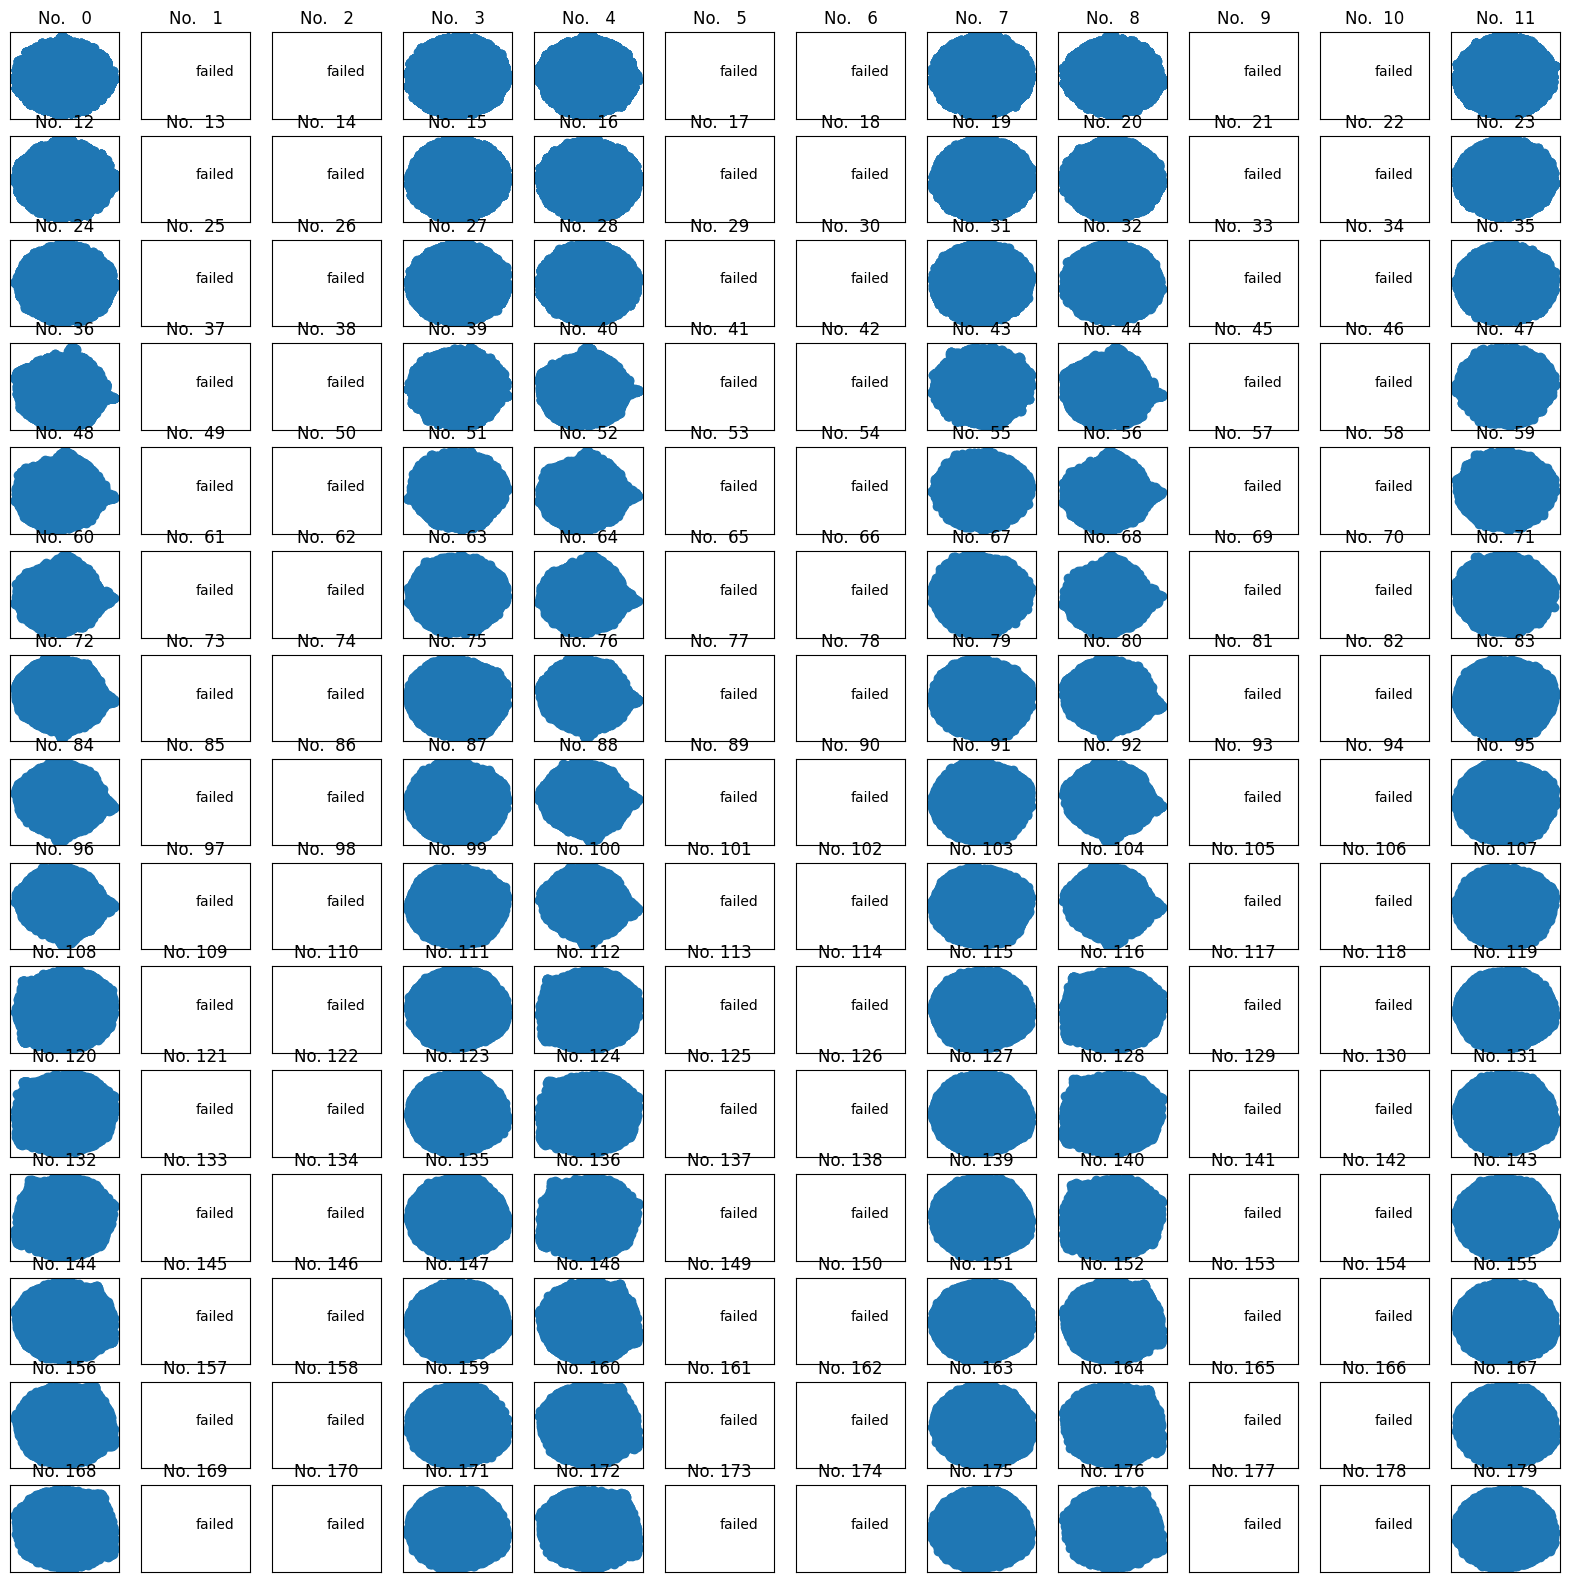

In [17]:
fig = plt.figure(figsize=(20, 20))
for i, (_umap, _hparams) in enumerate(zip(umaps, umap_used_hparams)):
# for i, (_umap, _hparams) in enumerate(zip(umaps, umap_hparams.iter_rows())):
    complete_is = _hparams[1]
    ax = fig.add_subplot(15, 12, i+1)
    ax.set_title(f"No. {i:3}")
    ax.set_xticks([])
    ax.set_yticks([])

    if complete_is:
        try:
            X_emb = _umap.transform(X)
            ax.scatter(X_emb[:, 0], X_emb[:, 1])
        except:
            ax.text(0.5, 0.5, s="transforming error")
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
    else:
        ax.text(0.5, 0.5, s="failed")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)


# 保存したモデルの読み出し

In [12]:
load_model_path = Path("../models/UMAP/2023-11-24/models/")
umaps: list[umap.UMAP] = []

for ppath in sorted(load_model_path.glob("*.pickle")):
    print(ppath.stem)
    with open(ppath, "rb") as f:
        umaps.append(pickle.load(f))

load_hparam_path = load_model_path.parent / "learned_umap_configs.txt"
umap_hparams = pl.read_csv(load_hparam_path)


In [32]:
idx_of_used_metric.columns


['No.', 'complete', 'n_neighbors', 'min_dist', 'n_component', 'metric']

In [39]:
umap_hparams.select("n_neighbors").unique()


n_neighbors
i64
4
16
2
8
32


# それぞれのメトリクスごとに分けて描写

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:23<00:00,  5.79s/it]


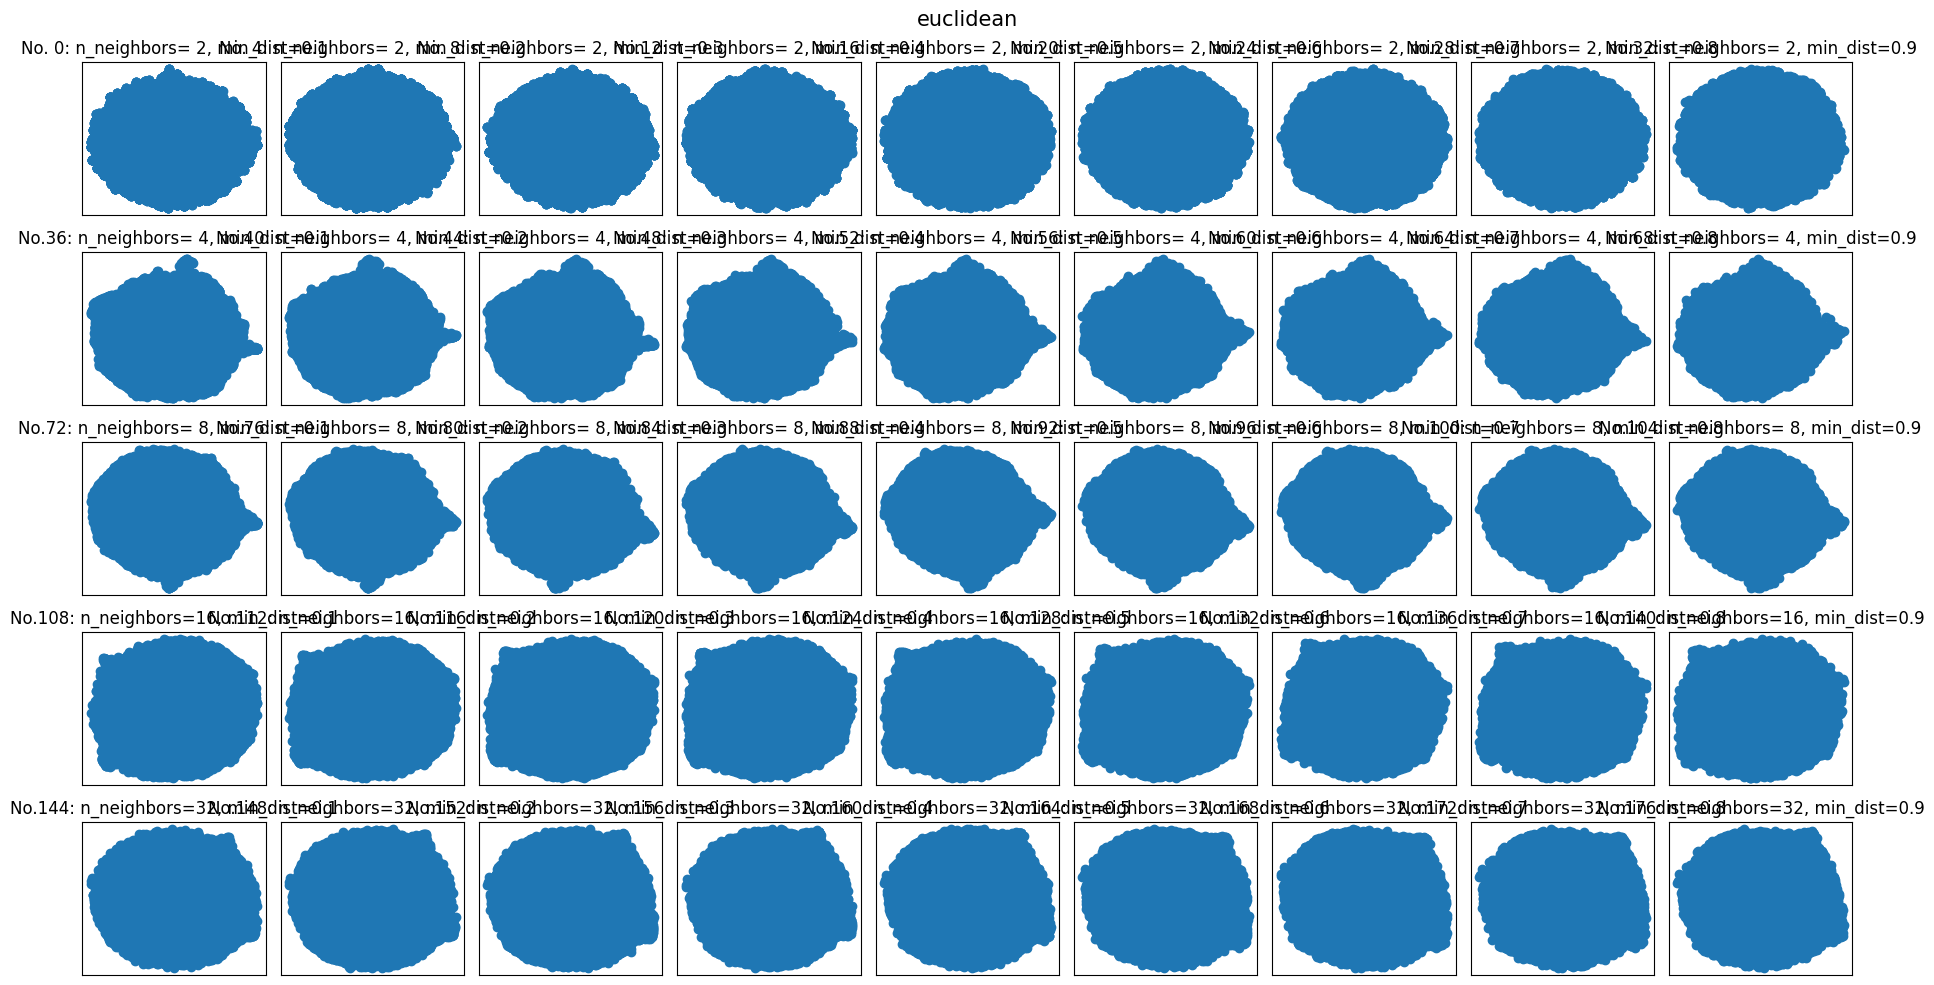

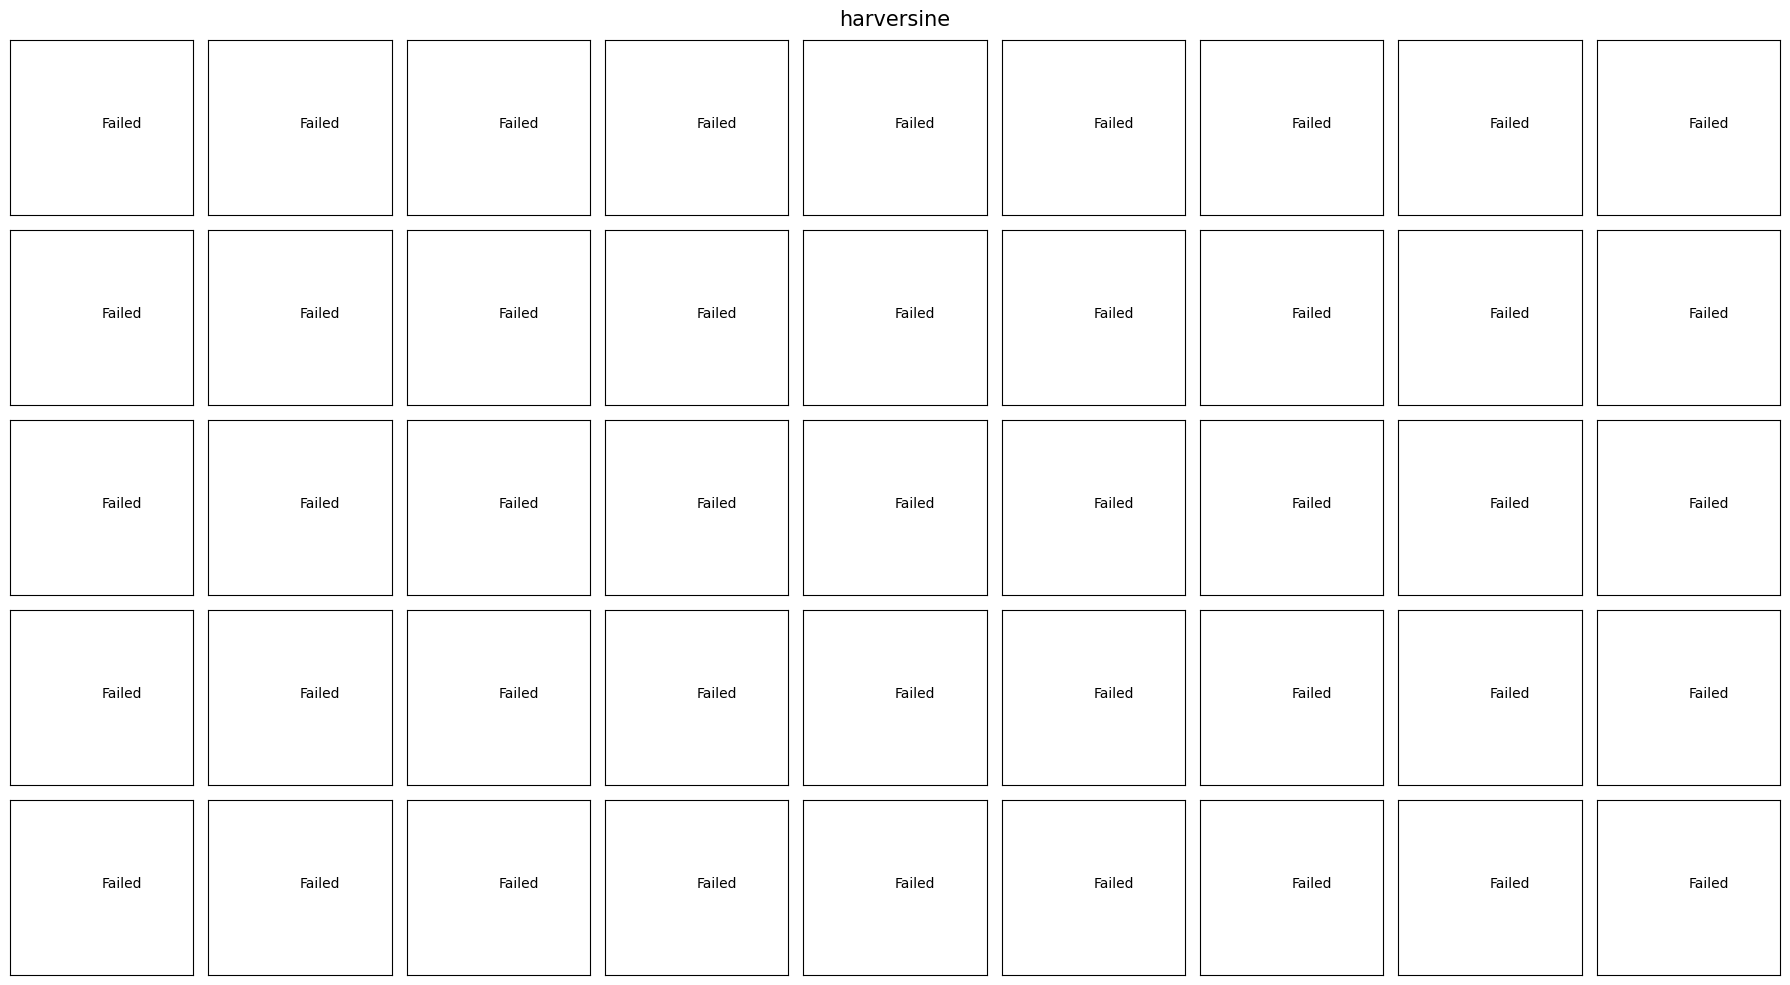

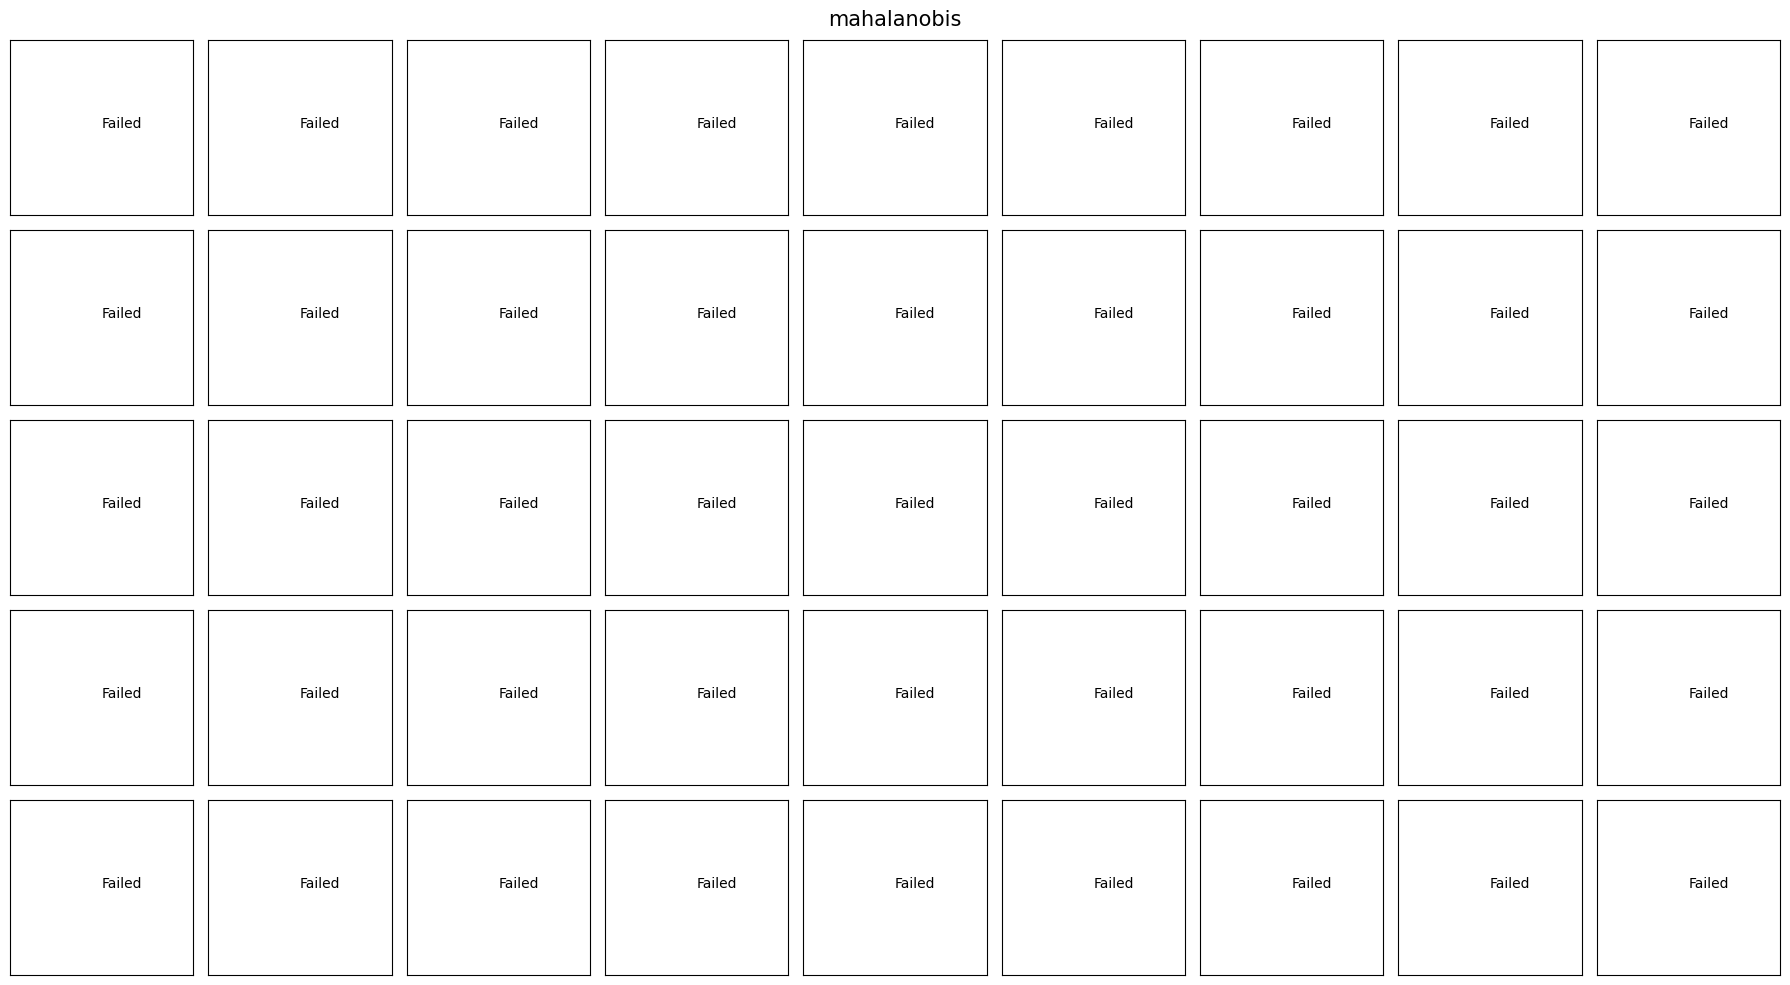

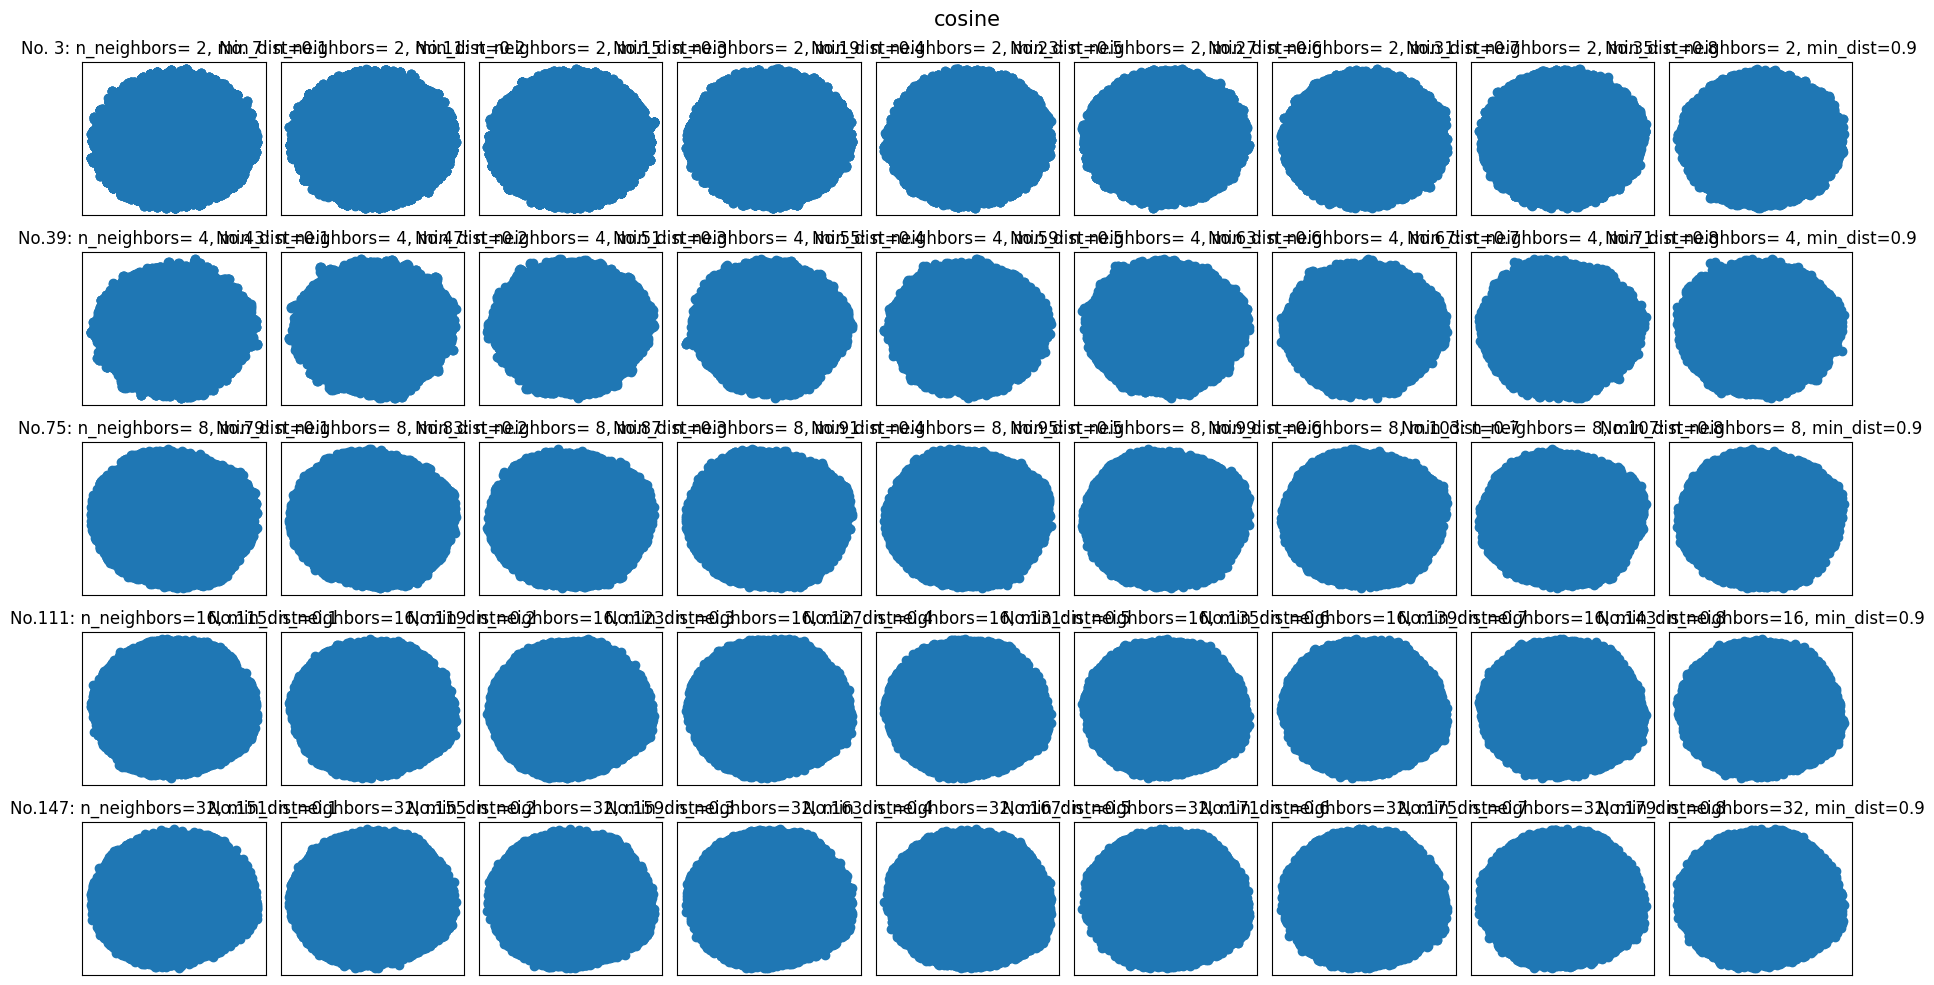

In [47]:
# TODO: 各metricごとに可視化する。
# metric ごとのインデックスを列とする
# イメージ：
# idx of euclidian: 1, 4, 6,
# idx of manhattan: 2, 3,
# idx of cosine   : 5, 7, 8,

save_fig_path = report_dir / "figures" / name_of_feature_extractor / "2023-07-10" / "12-37-46" / "DimReduce" / "UMAP"
used_metrics = umap_hparams.select("metric").unique(maintain_order=True).to_numpy().flatten()

for metric in tqdm.tqdm(used_metrics):
    idx_of_used_metric = umap_hparams.filter(
        pl.col("metric") == metric
    )

    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(f"{metric}", fontsize=15)

    for i, (idx, is_complete, n_neighbors, min_dist, _, _) in enumerate( idx_of_used_metric.iter_rows() ):
        ax = fig.add_subplot(5, 9, i + 1)
        if is_complete:
            ax.set_title(f"No.{idx:2}: {n_neighbors=:2}, {min_dist=:0.3}")
            X_emb = umaps[idx].transform(X)
            ax.scatter(
                X_emb[:, 0],
                X_emb[:, 1],
            )
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.text(1, 1, "Failed")
            ax.set_xlim(0, 2)
            ax.set_ylim(0, 2)
            ax.set_xticks([])
            ax.set_yticks([])

    fig.tight_layout()
    fig.savefig(save_fig_path / "2023-11-24" / f"tuned_by_{metric}.png", )


In [43]:

save_fig_path = report_dir / "figures" / name_of_feature_extractor / "2023-07-10" / "12-37-46" / "DimReduce" / "UMAP"


In [44]:
save_fig_path.exists()


True